# **스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 target을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# 필요하다고 판단되는 라이브러리를 추가하세요.
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 : 
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 : 
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [2]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [3]:
data = pd.read_csv('data01_train.csv')
features = pd.read_csv('features.csv')

In [4]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [5]:
features.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tBodyAcc-mean()-X,5881.0,0.274811,0.067614,-0.503823,0.262919,0.277154,0.288526,1.000000
tBodyAcc-mean()-Y,5881.0,-0.017799,0.039422,-0.684893,-0.024877,-0.017221,-0.010920,1.000000
tBodyAcc-mean()-Z,5881.0,-0.109396,0.058373,-1.000000,-0.121051,-0.108781,-0.098163,1.000000
tBodyAcc-std()-X,5881.0,-0.603138,0.448807,-1.000000,-0.992774,-0.943933,-0.242130,1.000000
tBodyAcc-std()-Y,5881.0,-0.509815,0.501815,-0.999844,-0.977680,-0.844575,-0.034499,0.916238
...,...,...,...,...,...,...,...,...
"angle(tBodyGyroJerkMean,gravityMean)",5881.0,-0.007099,0.476738,-1.000000,-0.373345,-0.000847,0.356236,0.996078
"angle(X,gravityMean)",5881.0,-0.491501,0.509069,-1.000000,-0.811397,-0.709441,-0.511330,0.977344
"angle(Y,gravityMean)",5881.0,0.059299,0.297340,-1.000000,-0.018203,0.182893,0.248435,0.478157
"angle(Z,gravityMean)",5881.0,-0.054594,0.278479,-0.980143,-0.141555,0.003951,0.111932,1.000000


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64
Activity
LAYING                0.189594
STANDING              0.184833
SITTING               0.175480
WALKING               0.169699
WALKING_UPSTAIRS      0.145894
WALKING_DOWNSTAIRS    0.134501
Name: proportion, dtype: float64


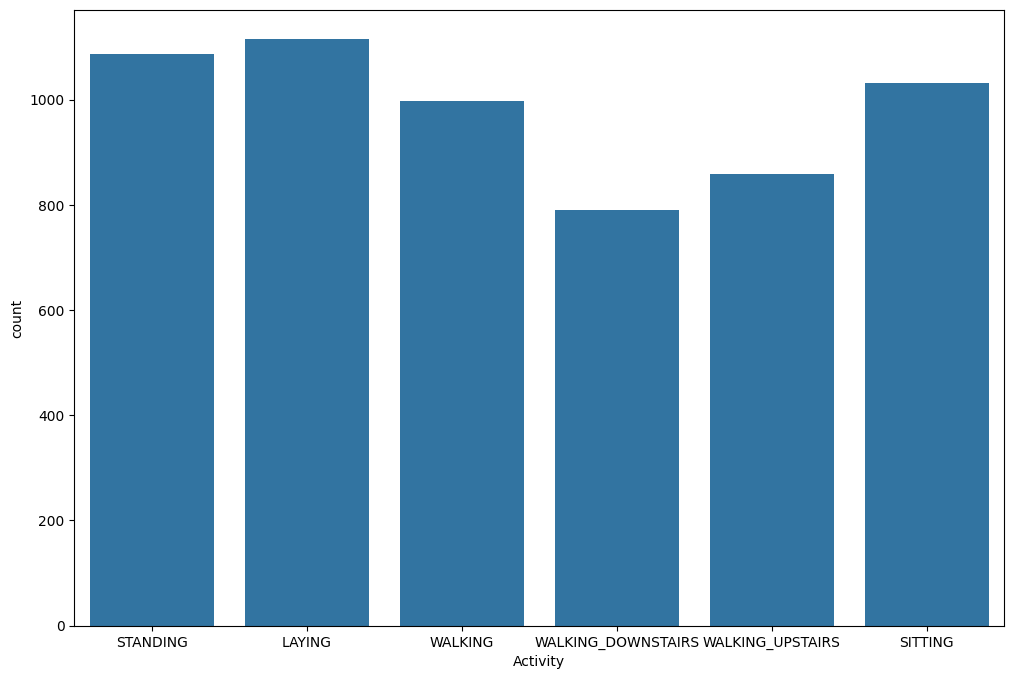

In [8]:
target = 'Activity'

print(data[target].value_counts())
print('=' * 30)
print(data[target].value_counts(normalize = True))
print('=' * 30)

plt.figure(figsize = (12, 8))
sns.countplot(x = data[target])
plt.show()

- 정적 행동의 수가 동적 행동보다 많다
    - 누워있거나 서있는 경우가 가장 많다

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [9]:
sensor = features.groupby(by = 'sensor', as_index = False)['feature_name'].value_counts()
sensor.groupby(by = 'sensor', as_index = False)['count'].sum()

,sensor,count
0,angle,7
1,fBodyAcc,79
2,fBodyAccJerk,79
3,fBodyAccMag,13
4,fBodyBodyAccJerkMag,13
5,fBodyBodyGyroJerkMag,13
6,fBodyBodyGyroMag,13
7,fBodyGyro,79
8,tBodyAcc,40
9,tBodyAccJerk,40


In [10]:
agg = features.groupby(by = 'agg', as_index = False)['feature_name'].value_counts()
agg.groupby(by = 'agg', as_index = False)['count'].sum()

,agg,count
0,X,1
1,Y,1
2,Z,1
3,arCoeff(),60
4,arCoeff()1,5
5,arCoeff()2,5
6,arCoeff()3,5
7,arCoeff()4,5
8,bandsEnergy(),126
9,correlation(),15


In [11]:
axis = features.groupby(by = 'axis', as_index = False)['feature_name'].value_counts()
axis.groupby(by = 'axis', as_index = False)['count'].sum()

,axis,count
0,"1,16",5
1,"1,16.1",2
2,"1,16.2",2
3,"1,24",5
4,"1,24.1",2
...,...,...
57,"Z,2",5
58,"Z,3",5
59,"Z,4",5
60,gravity,1


## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다. 
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

In [12]:
X = data.drop(target, axis = 1)
y = data.loc[:, target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
feature_importances = plot_feature_importance(model_rf.feature_importances_, X_train.columns, result_only = True)

In [14]:
feature_importances

,feature_name,feature_importance
0,tGravityAcc-mean()-X,0.033213
1,tGravityAcc-max()-Y,0.029725
2,tGravityAcc-max()-X,0.026256
3,tGravityAcc-min()-X,0.025537
4,"angle(X,gravityMean)",0.024184
...,...,...
557,"fBodyGyro-bandsEnergy()-49,56.1",0.000102
558,fBodyAcc-entropy()-Y,0.000101
559,tBodyAccJerkMag-arCoeff()3,0.000075
560,fBodyAccJerk-entropy()-Y,0.000062


### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

In [15]:
n, m = 5, 5
top_n_features = list(feature_importances['feature_name'][:n])
bottom_m_features = list(feature_importances['feature_name'][-m:])

In [16]:
top_n_features

['tGravityAcc-mean()-X',
 'tGravityAcc-max()-Y',
 'tGravityAcc-max()-X',
 'tGravityAcc-min()-X',
 'angle(X,gravityMean)']

In [17]:
def kde_plot(features, target, data):
    plt.figure(figsize = (15, 9))
    for i in range(len(features)):
        plt.subplot(2, 3, i + 1)
        sns.kdeplot(x= features[i], data = data, hue = target,
            common_norm = False)
    plt.show()

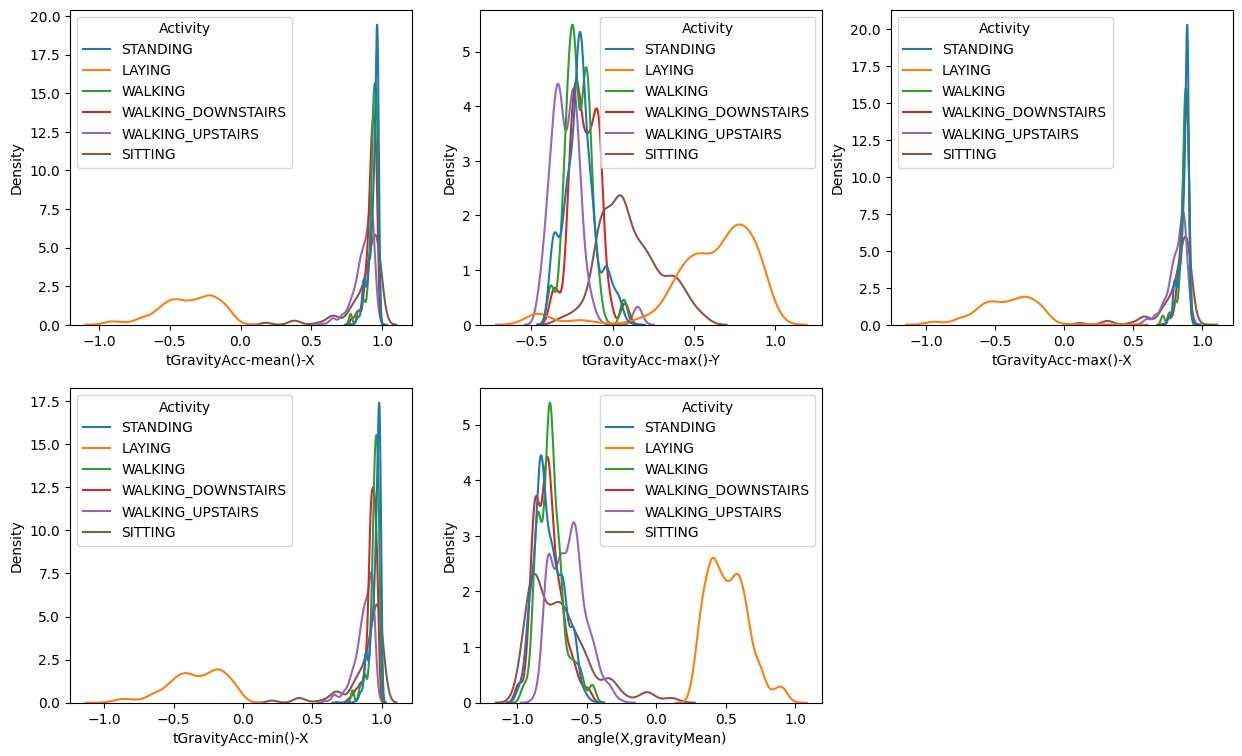

In [18]:
kde_plot(top_n_features, target, data)

- LAYING : Y축 방향 움직임이 크다
- 나머지 X축 방향 움직임이 크다
- 중력 가속도가 많이 중요

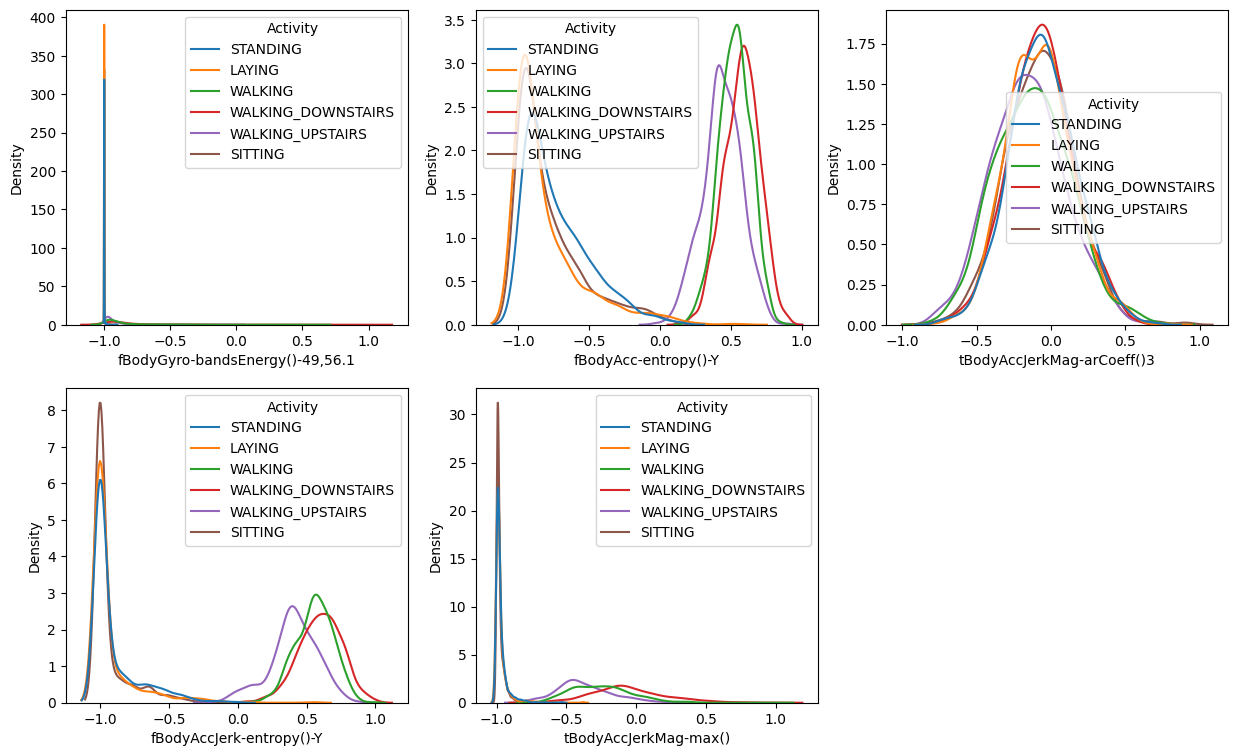

In [19]:
kde_plot(bottom_m_features, target, data)

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오. 


In [20]:
fi_df = pd.merge(features, feature_importances)
fi_df.head()

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000279
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000308
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000136
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.005567
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000400


In [21]:
n = 5
sensor_sum = fi_df.groupby(by = 'sensor', as_index = False)['feature_importance'].sum()
sensor_sum = sensor_sum.sort_values('feature_importance', ascending = False)
sensor_sum.head()

,sensor,feature_importance
16,tGravityAcc,0.336072
1,fBodyAcc,0.089308
2,fBodyAccJerk,0.086659
7,fBodyGyro,0.080908
9,tBodyAccJerk,0.062759


In [22]:
sensor_agg_sum = fi_df.groupby(by = ['sensor', 'agg'], as_index = False)['feature_importance'].sum()
sensor_agg_sum = sensor_agg_sum.sort_values('feature_importance', ascending = False)
sensor_agg_sum.head()

,sensor,agg,feature_importance
197,tGravityAcc,arCoeff(),0.076226
203,tGravityAcc,max(),0.067154
204,tGravityAcc,mean(),0.060736
205,tGravityAcc,min(),0.058756
199,tGravityAcc,energy(),0.049210


- 선형적인 중력 가속도 관련 변수들의 중요도가 높았다
- sensor + agg 별로 보니 중력가속도의 중요도가 높음을 추가로 알 수 있다
- sensor 별로 보면 중력 가속도가 중요

## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 target을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [23]:
data['is_dynamic'] = np.where(data['Activity'].isin(['STANDING', 'SITTING', 'LAYING']), 0, 1)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1


#### 2) 기본모델 생성

In [24]:
target = 'is_dynamic'
X = data.drop(list(data)[562:], axis = 1)
y = data.loc[:, target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### 3) 변수중요도 상위 5개 분석

In [25]:
n = 5

feature_importances = plot_feature_importance(model_rf.feature_importances_, X_train.columns, result_only = True)
top_n_features = list(feature_importances['feature_name'][:n])
top_n_features

['tBodyGyroJerk-iqr()-Z',
 'fBodyAccJerk-std()-X',
 'fBodyAcc-entropy()-X',
 'fBodyAccJerk-max()-X',
 'tBodyAccJerk-entropy()-X']

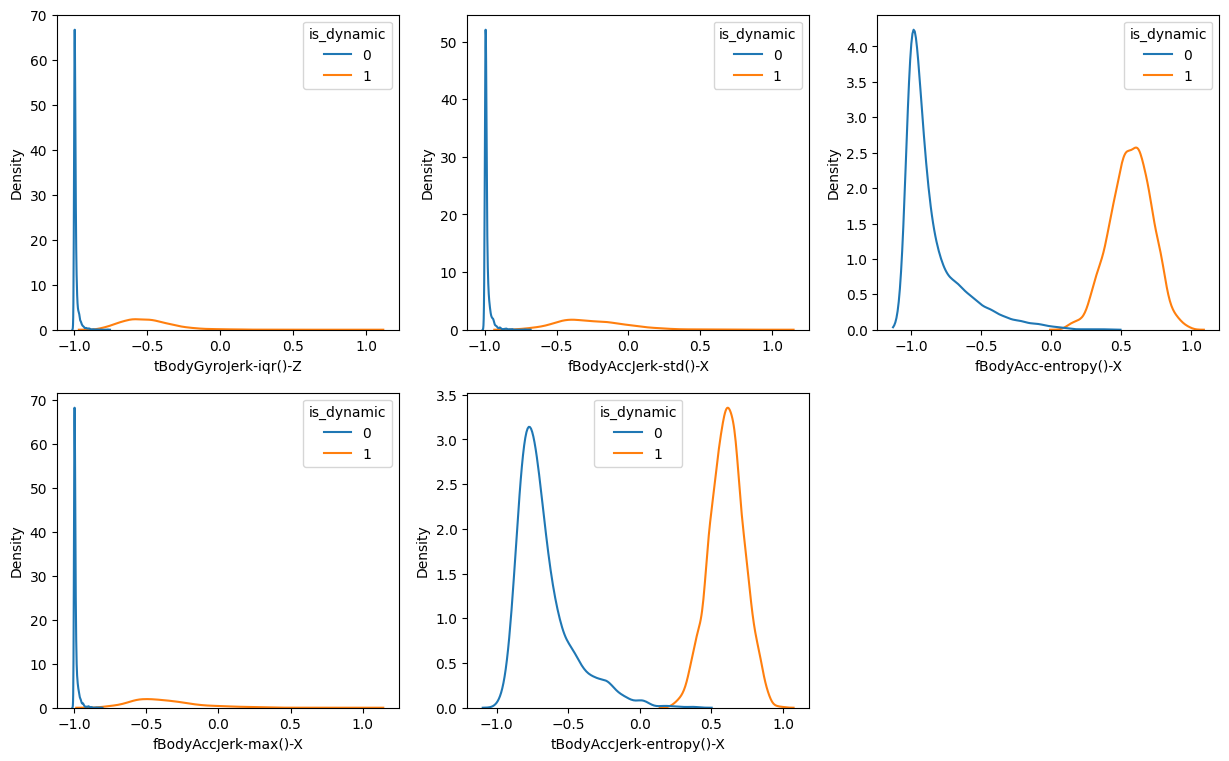

In [26]:
kde_plot(top_n_features, target, data)

#### 4) feature 그룹별 분석

In [27]:
fi_dm_df = pd.merge(features, feature_importances)
fi_dm_df.head()

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000000
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000017
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000024
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.000000
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000000


In [28]:
n = 5
sensor_sum = fi_dm_df.groupby(by = 'sensor', as_index = False)['feature_importance'].sum()
sensor_sum = sensor_sum.sort_values('feature_importance', ascending = False)
sensor_sum.head()

,sensor,feature_importance
2,fBodyAccJerk,0.280232
9,tBodyAccJerk,0.189779
1,fBodyAcc,0.139506
13,tBodyGyroJerk,0.109806
10,tBodyAccJerkMag,0.089803


In [29]:
sensor_agg_sum = fi_dm_df.groupby(by = ['sensor', 'agg'], as_index = False)['feature_importance'].sum()
sensor_agg_sum = sensor_agg_sum.sort_values('feature_importance', ascending = False)
sensor_agg_sum.head()

,sensor,agg,feature_importance
21,fBodyAccJerk,bandsEnergy(),0.090364
164,tBodyGyroJerk,iqr(),0.069948
34,fBodyAccJerk,std(),0.049973
115,tBodyAccJerk,entropy(),0.049902
9,fBodyAcc,entropy(),0.049795


- 전체 변수에서 보면 몸의 회전 움직임과 몸의 선형적인 움직임이 중요
- sensor별로 보면 몸의 선형적인 움직임이 가장 중요
- sensor + agg별로 보면 몸의 선형적인 움직임이 가장 중요

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [30]:
data['is_standing'] = np.where(data['Activity'] == 'STANDING', 1, 0)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic,is_standing
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING,0,1
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING,0,1
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING,1,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1,0


In [31]:
target = 'is_standing'
X = data.drop(list(data)[562:], axis = 1)
y = data.loc[:, target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
n = 5

feature_importances = plot_feature_importance(model_rf.feature_importances_, X_train.columns, result_only = True)
top_n_features = list(feature_importances['feature_name'][:n])
top_n_features

['tGravityAcc-max()-Y',
 'angle(Y,gravityMean)',
 'tGravityAcc-mean()-Y',
 'tGravityAcc-min()-Y',
 'angle(Z,gravityMean)']

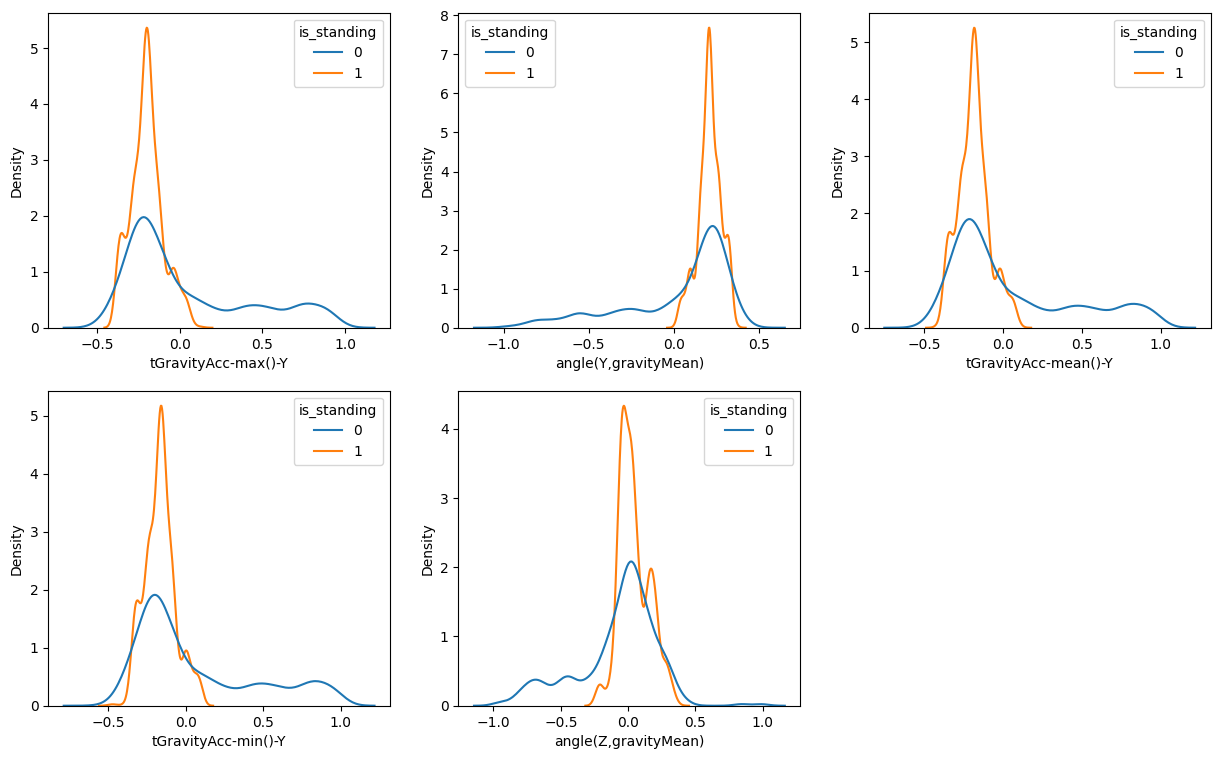

In [33]:
kde_plot(top_n_features, target, data)

In [34]:
fi_st_df = pd.merge(features, feature_importances)
fi_st_df.head()

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000390
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000875
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000443
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.005170
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000346


In [35]:
n = 5
sensor_sum = fi_st_df.groupby(by = 'sensor', as_index = False)['feature_importance'].sum()
sensor_sum = sensor_sum.sort_values('feature_importance', ascending = False)
sensor_sum.head()

,sensor,feature_importance
16,tGravityAcc,0.378197
0,angle,0.116826
7,fBodyGyro,0.106340
1,fBodyAcc,0.095673
8,tBodyAcc,0.065597


In [36]:
sensor_agg_sum = fi_st_df.groupby(by = ['sensor', 'agg'], as_index = False)['feature_importance'].sum()
sensor_agg_sum = sensor_agg_sum.sort_values('feature_importance', ascending = False)
sensor_agg_sum.head()

,sensor,agg,feature_importance
203,tGravityAcc,max(),0.109081
204,tGravityAcc,mean(),0.092858
205,tGravityAcc,min(),0.080001
1,angle,Y,0.063110
87,fBodyGyro,bandsEnergy(),0.057710


- 전체 변수 중요도에서는 중력 가속도가 중요
- sensor에서는 중력 가속도 중요
- sensor + agg에서는 중력 관련 변수들이 중요

### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [37]:
data['is_sitting'] = np.where(data['Activity'] == 'SITTING', 1, 0)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic,is_standing,is_sitting
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING,0,1,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING,0,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING,0,1,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING,1,0,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1,0,0


In [38]:
target = 'is_sitting'
X = data.drop(list(data)[562:], axis = 1)
y = data.loc[:, target]
X.head()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [39]:
n = 5

feature_importances = plot_feature_importance(model_rf.feature_importances_, X_train.columns, result_only = True)
top_n_features = list(feature_importances['feature_name'][:n])
top_n_features

['angle(Y,gravityMean)',
 'tGravityAcc-max()-Y',
 'tGravityAcc-min()-Y',
 'angle(X,gravityMean)',
 'tGravityAcc-mean()-Y']

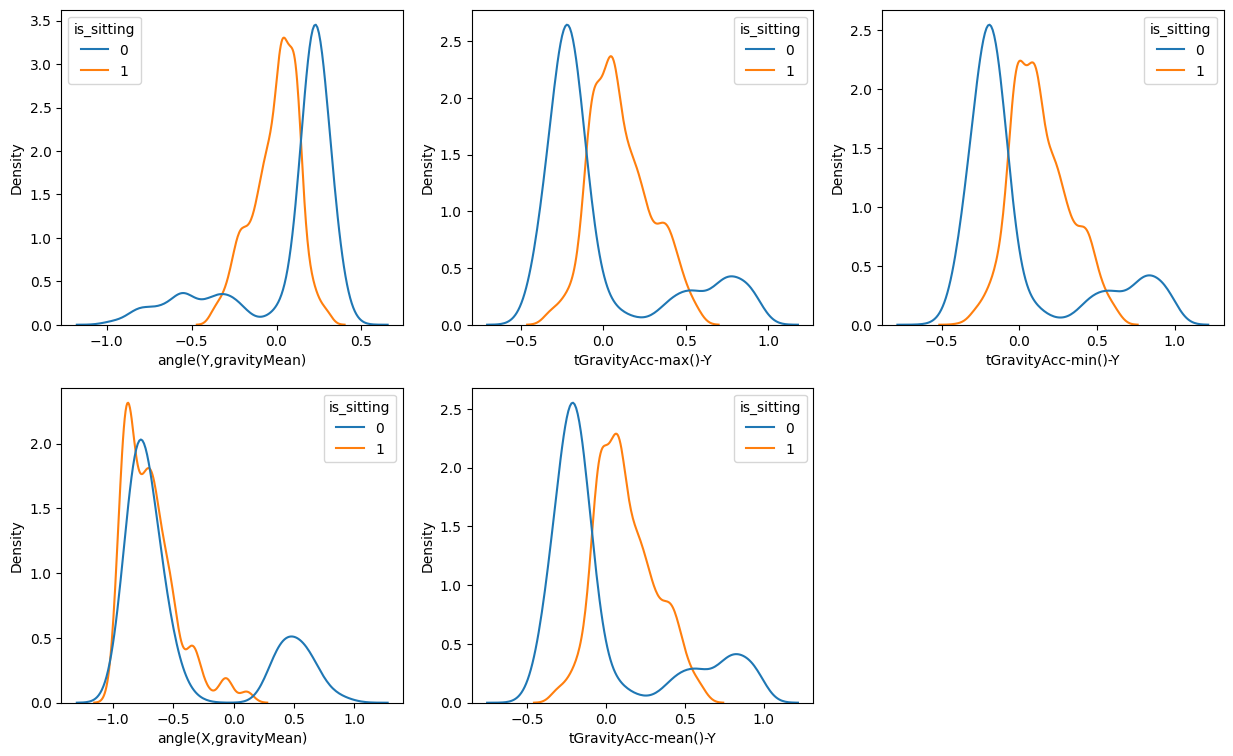

In [40]:
kde_plot(top_n_features, target, data)

In [41]:
fi_si_df = pd.merge(features, feature_importances)
fi_si_df.head()

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000252
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000553
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000305
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.001472
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000624


In [42]:
n = 5
sensor_sum = fi_si_df.groupby(by = 'sensor', as_index = False)['feature_importance'].sum()
sensor_sum = sensor_sum.sort_values('feature_importance', ascending = False)
sensor_sum.head()

,sensor,feature_importance
7,fBodyGyro,0.339032
16,tGravityAcc,0.299504
0,angle,0.106252
12,tBodyGyro,0.098328
13,tBodyGyroJerk,0.058849


In [43]:
sensor_agg_sum = fi_si_df.groupby(by = ['sensor', 'agg'], as_index = False)['feature_importance'].sum()
sensor_agg_sum = sensor_agg_sum.sort_values('feature_importance', ascending = False)
sensor_agg_sum.head()

,sensor,agg,feature_importance
87,fBodyGyro,bandsEnergy(),0.228948
205,tGravityAcc,min(),0.080487
203,tGravityAcc,max(),0.076826
204,tGravityAcc,mean(),0.060787
1,angle,Y,0.051174


- 전체 변수 중요도에서는 중력 가속도(선형)가 가장 중요
- sensor에서는 몸의 회전과 중력 가속도 중요
- sensor + agg에서는 몸의 회전이 가장 중요

### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [44]:
data['is_laying'] = np.where(data['Activity'] == 'LAYING', 1, 0)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic,is_standing,is_sitting,is_laying
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,0.072790,-0.601120,0.331298,0.165163,21,STANDING,0,1,0,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,0.771524,0.345205,-0.769186,-0.147944,15,LAYING,0,0,0,1
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.021528,-0.833564,0.202434,-0.032755,11,STANDING,0,1,0,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.072944,-0.695819,0.287154,0.111388,17,WALKING,1,0,0,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1,0,0,0


In [45]:
target = 'is_laying'
X = data.drop(list(data)[562:], axis = 1)
y = data.loc[:, target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [46]:
n = 5

feature_importances = plot_feature_importance(model_rf.feature_importances_, X_train.columns, result_only = True)
top_n_features = list(feature_importances['feature_name'][:n])
top_n_features

['tGravityAcc-mean()-X',
 'tGravityAcc-max()-X',
 'tGravityAcc-energy()-X',
 'angle(X,gravityMean)',
 'tGravityAcc-energy()-Y']

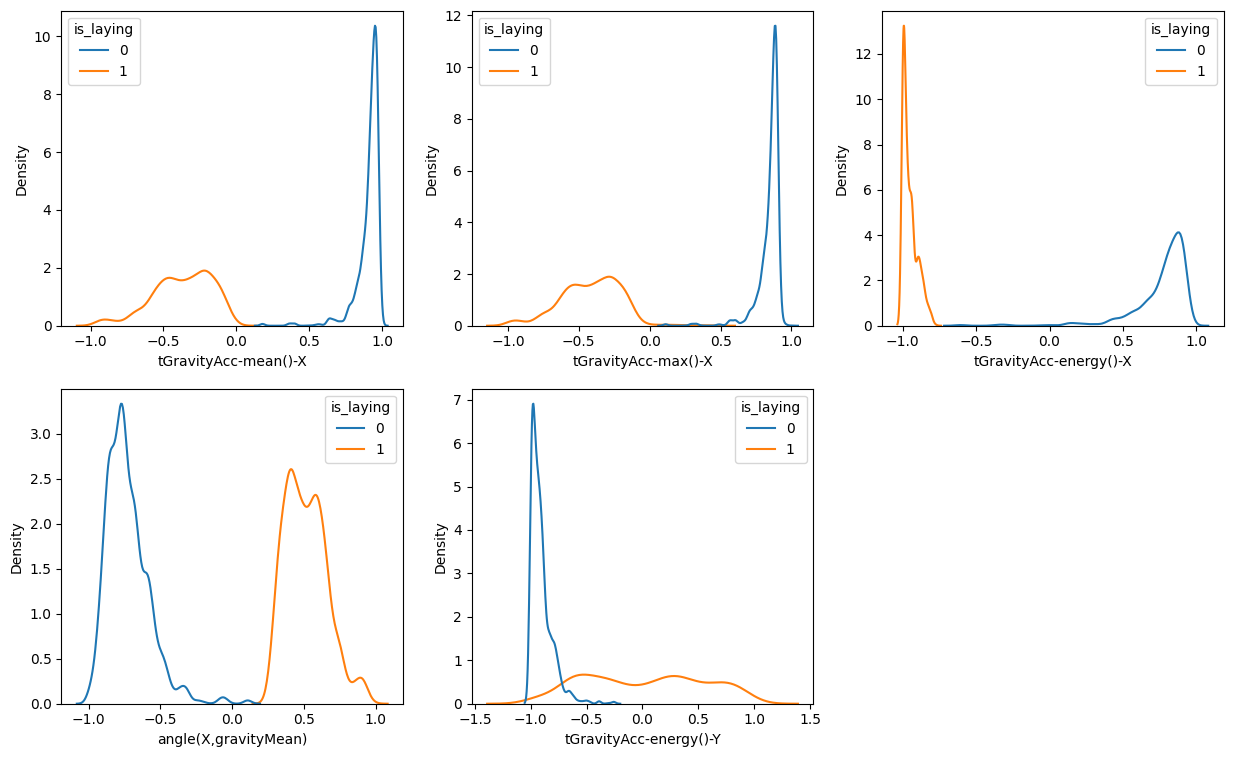

In [47]:
kde_plot(top_n_features, target, data)

In [48]:
fi_la_df = pd.merge(features, feature_importances)
fi_la_df.head()

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000173
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000159
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000026
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.000351
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000040


In [49]:
n = 5
sensor_sum = fi_la_df.groupby(by = 'sensor', as_index = False)['feature_importance'].sum()
sensor_sum = sensor_sum.sort_values('feature_importance', ascending = False)
sensor_sum.head()

,sensor,feature_importance
16,tGravityAcc,0.661838
0,angle,0.142408
12,tBodyGyro,0.037850
2,fBodyAccJerk,0.032410
1,fBodyAcc,0.028284


In [50]:
sensor_agg_sum = fi_la_df.groupby(by = ['sensor', 'agg'], as_index = False)['feature_importance'].sum()
sensor_agg_sum = sensor_agg_sum.sort_values('feature_importance', ascending = False)
sensor_agg_sum.head()

,sensor,agg,feature_importance
203,tGravityAcc,max(),0.174381
204,tGravityAcc,mean(),0.168906
199,tGravityAcc,energy(),0.162187
205,tGravityAcc,min(),0.117030
0,angle,X,0.065231


- 전체 변수 중요도에서는 중력 가속도가 가장 중요한 변수들이다
- sensor에서는 중력 가속도 중요
- sensor + agg에서는 중력 가속도가 가장 중요

### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [51]:
data['is_walking'] = np.where(data['Activity'] == 'WALKING', 1, 0)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic,is_standing,is_sitting,is_laying,is_walking
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.601120,0.331298,0.165163,21,STANDING,0,1,0,0,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,0.345205,-0.769186,-0.147944,15,LAYING,0,0,0,1,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.833564,0.202434,-0.032755,11,STANDING,0,1,0,0,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.695819,0.287154,0.111388,17,WALKING,1,0,0,0,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1,0,0,0,0


In [52]:
target = 'is_walking'
X = data.drop(list(data)[562:], axis = 1)
y = data.loc[:, target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [53]:
n = 5

feature_importances = plot_feature_importance(model_rf.feature_importances_, X_train.columns, result_only = True)
top_n_features = list(feature_importances['feature_name'][:n])
top_n_features

['fBodyAccMag-std()',
 'fBodyAcc-bandsEnergy()-1,16',
 'fBodyAcc-max()-X',
 'tBodyAcc-correlation()-X,Y',
 'tGravityAcc-arCoeff()-X,2']

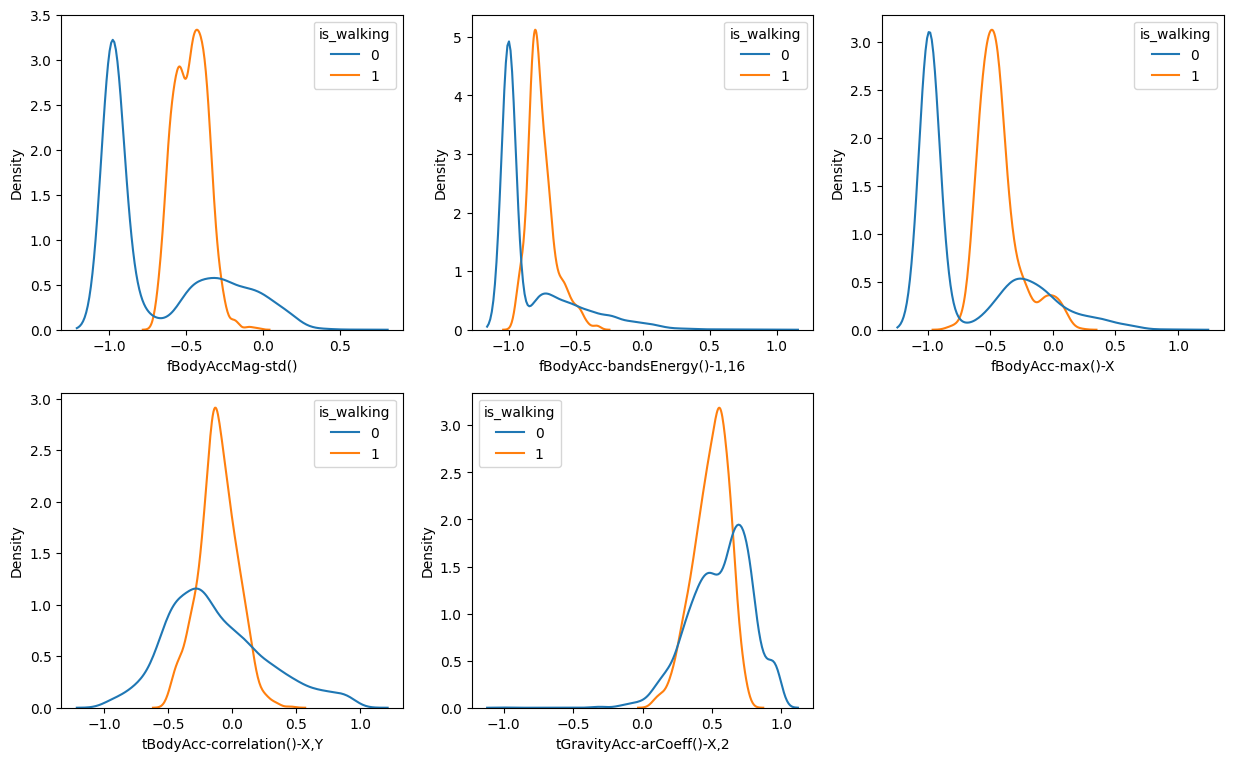

In [54]:
kde_plot(top_n_features, target, data)

In [55]:
fi_wk_df = pd.merge(features, feature_importances)
fi_wk_df.head()

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000140
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000166
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000151
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007518
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000169


In [56]:
n = 5
sensor_sum = fi_wk_df.groupby(by = 'sensor', as_index = False)['feature_importance'].sum()
sensor_sum = sensor_sum.sort_values('feature_importance', ascending = False)
sensor_sum.head()

,sensor,feature_importance
16,tGravityAcc,0.160941
1,fBodyAcc,0.137324
2,fBodyAccJerk,0.100525
7,fBodyGyro,0.092160
13,tBodyGyroJerk,0.088481


In [57]:
sensor_agg_sum = fi_wk_df.groupby(by = ['sensor', 'agg'], as_index = False)['feature_importance'].sum()
sensor_agg_sum = sensor_agg_sum.sort_values('feature_importance', ascending = False)
sensor_agg_sum.head()

,sensor,agg,feature_importance
197,tGravityAcc,arCoeff(),0.097880
7,fBodyAcc,bandsEnergy(),0.077670
87,fBodyGyro,bandsEnergy(),0.070006
21,fBodyAccJerk,bandsEnergy(),0.045885
47,fBodyAccMag,std(),0.032203


- 전체 변수 중요도에서는 몸의 움직임이 가장 중요
- sensor에서는 중력 가속도, 몸의 움직임 등이 중요
- sensor + agg에서는 몸의 회전, 중력 가속도, 몸의 움직임이 가장 중요

### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [58]:
data['is_walking_up'] = np.where(data['Activity'] == 'WALKING_UPSTAIRS', 1, 0)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic,is_standing,is_sitting,is_laying,is_walking,is_walking_up
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,0.331298,0.165163,21,STANDING,0,1,0,0,0,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.769186,-0.147944,15,LAYING,0,0,0,1,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.202434,-0.032755,11,STANDING,0,1,0,0,0,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.287154,0.111388,17,WALKING,1,0,0,0,1,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1,0,0,0,0,0


In [59]:
target = 'is_walking_up'
X = data.drop(list(data)[562:], axis = 1)
y = data.loc[:, target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [60]:
n = 5

feature_importances = plot_feature_importance(model_rf.feature_importances_, X_train.columns, result_only = True)
top_n_features = list(feature_importances['feature_name'][:n])
top_n_features

['tGravityAcc-min()-Y',
 'tGravityAcc-arCoeff()-Z,2',
 'tGravityAcc-arCoeff()-Z,3',
 'fBodyGyro-maxInds-Z',
 'tGravityAcc-arCoeff()-Z,1']

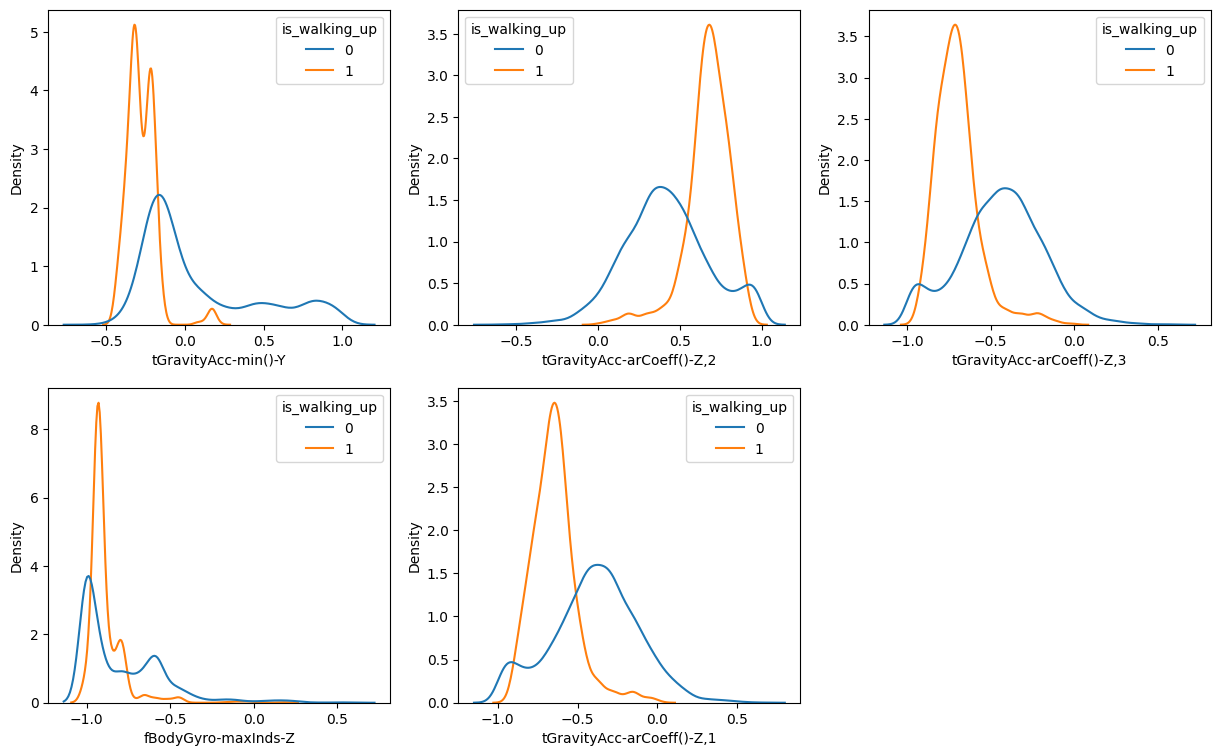

In [61]:
kde_plot(top_n_features, target, data)

In [62]:
fi_wku_df = pd.merge(features, feature_importances)
fi_wku_df.head()

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000218
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000897
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000120
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.006994
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000339


In [63]:
n = 5
sensor_sum = fi_wku_df.groupby(by = 'sensor', as_index = False)['feature_importance'].sum()
sensor_sum = sensor_sum.sort_values('feature_importance', ascending = False)
sensor_sum.head()

,sensor,feature_importance
16,tGravityAcc,0.271613
1,fBodyAcc,0.190458
2,fBodyAccJerk,0.113719
9,tBodyAccJerk,0.056193
7,fBodyGyro,0.056166


In [64]:
sensor_agg_sum = fi_wku_df.groupby(by = ['sensor', 'agg'], as_index = False)['feature_importance'].sum()
sensor_agg_sum = sensor_agg_sum.sort_values('feature_importance', ascending = False)
sensor_agg_sum.head()

,sensor,agg,feature_importance
197,tGravityAcc,arCoeff(),0.157228
7,fBodyAcc,bandsEnergy(),0.087433
21,fBodyAccJerk,bandsEnergy(),0.048506
205,tGravityAcc,min(),0.042122
13,fBodyAcc,max(),0.032908


- 전체 변수 중요도에서는 중력 가속도가 가장 중요
- sensor에서는 몸의 움직임, 중력 가속도 등이 중요
- sensor + agg에서는 중력 가속도, 몸의 움직임이 가장 중요

### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [65]:
data['is_walking_down'] = np.where(data['Activity'] == 'WALKING_DOWNSTAIRS', 1, 0)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(Z,gravityMean)",subject,Activity,is_dynamic,is_standing,is_sitting,is_laying,is_walking,is_walking_up,is_walking_down
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,0.165163,21,STANDING,0,1,0,0,0,0,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.147944,15,LAYING,0,0,0,1,0,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.032755,11,STANDING,0,1,0,0,0,0,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.111388,17,WALKING,1,0,0,0,1,0,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,0.137758,17,WALKING_DOWNSTAIRS,1,0,0,0,0,0,1


In [66]:
target = 'is_walking_down'
X = data.drop(list(data)[562:], axis = 1)
y = data.loc[:, target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [67]:
n = 5

feature_importances = plot_feature_importance(model_rf.feature_importances_, X_train.columns, result_only = True)
top_n_features = list(feature_importances['feature_name'][:n])
top_n_features

['tBodyAccMag-std()',
 'tGravityAccMag-std()',
 'tBodyAccMag-mad()',
 'fBodyAccMag-energy()',
 'tGravityAccMag-mad()']

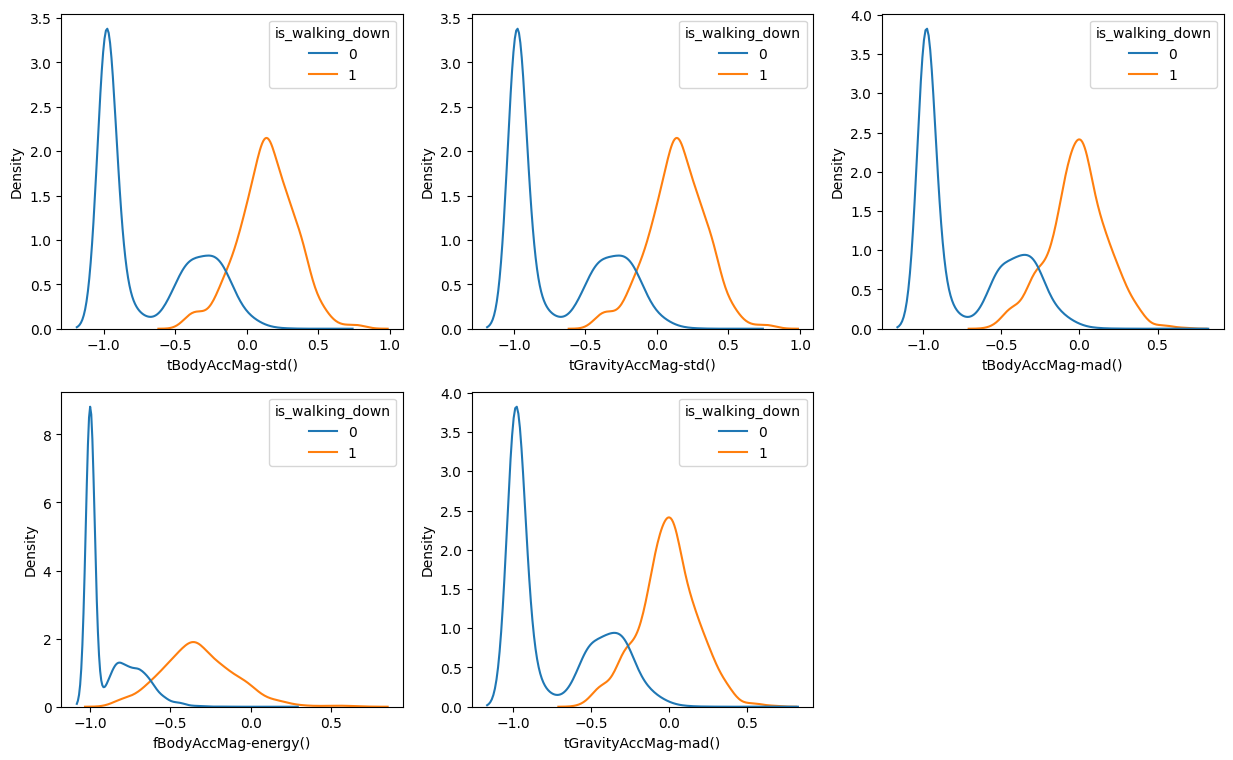

In [68]:
kde_plot(top_n_features, target, data)

In [69]:
fi_wkd_df = pd.merge(features, feature_importances)
fi_wkd_df.head()

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000082
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000323
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000290
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.022678
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000517


In [70]:
n = 5
sensor_sum = fi_wkd_df.groupby(by = 'sensor', as_index = False)['feature_importance'].sum()
sensor_sum = sensor_sum.sort_values('feature_importance', ascending = False)
sensor_sum.head()

,sensor,feature_importance
1,fBodyAcc,0.171236
3,fBodyAccMag,0.168888
11,tBodyAccMag,0.162062
17,tGravityAccMag,0.116350
8,tBodyAcc,0.104980


In [71]:
sensor_agg_sum = fi_wkd_df.groupby(by = ['sensor', 'agg'], as_index = False)['feature_importance'].sum()
sensor_agg_sum = sensor_agg_sum.sort_values('feature_importance', ascending = False)
sensor_agg_sum.head()

,sensor,agg,feature_importance
148,tBodyAccMag,std(),0.090652
7,fBodyAcc,bandsEnergy(),0.060695
220,tGravityAccMag,std(),0.054868
143,tBodyAccMag,mad(),0.043855
35,fBodyAccMag,energy(),0.037850


- 전체 변수 중요도에서는 몸의 움직임과 중력 가속도가 가장 중요
- sensor에서는 몸의 움직임이 중요
- sensor + agg에서는 몸의 움직임이 가장 중요

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

In [72]:
fi_dm_df.rename(columns = {'feature_importance' : 'feature_importance_dm'}, inplace = True)
fi_st_df.rename(columns = {'feature_importance' : 'feature_importance_st'}, inplace = True)
fi_si_df.rename(columns = {'feature_importance' : 'feature_importance_si'}, inplace = True)
fi_la_df.rename(columns = {'feature_importance' : 'feature_importance_la'}, inplace = True)
fi_wk_df.rename(columns = {'feature_importance' : 'feature_importance_wk'}, inplace = True)
fi_wku_df.rename(columns = {'feature_importance' : 'feature_importance_wku'}, inplace = True)
fi_wkd_df.rename(columns = {'feature_importance' : 'feature_importance_wkd'}, inplace = True)

In [73]:
df = pd.merge(fi_df, fi_dm_df)
df = pd.merge(df, fi_st_df)
df = pd.merge(df, fi_si_df)
df = pd.merge(df, fi_la_df)
df = pd.merge(df, fi_wk_df)
df = pd.merge(df, fi_wku_df)
df = pd.merge(df, fi_wkd_df)
df.head()

,sensor,agg,axis,feature_name,feature_importance,feature_importance_dm,feature_importance_st,feature_importance_si,feature_importance_la,feature_importance_wk,feature_importance_wku,feature_importance_wkd
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000279,0.000000,0.000390,0.000252,0.000173,0.000140,0.000218,0.000082
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000308,0.000017,0.000875,0.000553,0.000159,0.000166,0.000897,0.000323
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000136,0.000024,0.000443,0.000305,0.000026,0.000151,0.000120,0.000290
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.005567,0.000000,0.005170,0.001472,0.000351,0.007518,0.006994,0.022678
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000400,0.000000,0.000346,0.000624,0.000040,0.000169,0.000339,0.000517


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [74]:
joblib.dump(df, 'feature_importance.pkl')

['feature_importance.pkl']

In [75]:
df = joblib.load('feature_importance.pkl')
df.head()

,sensor,agg,axis,feature_name,feature_importance,feature_importance_dm,feature_importance_st,feature_importance_si,feature_importance_la,feature_importance_wk,feature_importance_wku,feature_importance_wkd
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000279,0.000000,0.000390,0.000252,0.000173,0.000140,0.000218,0.000082
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000308,0.000017,0.000875,0.000553,0.000159,0.000166,0.000897,0.000323
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000136,0.000024,0.000443,0.000305,0.000026,0.000151,0.000120,0.000290
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.005567,0.000000,0.005170,0.001472,0.000351,0.007518,0.006994,0.022678
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000400,0.000000,0.000346,0.000624,0.000040,0.000169,0.000339,0.000517
